## 5_Regularization (1) L1 & L2

In [0]:
%matplotlib inline
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import os
import time
import sys
from tqdm import tqdm

np.random.seed(30)
tf.random.set_random_seed(30)

## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [7]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 30


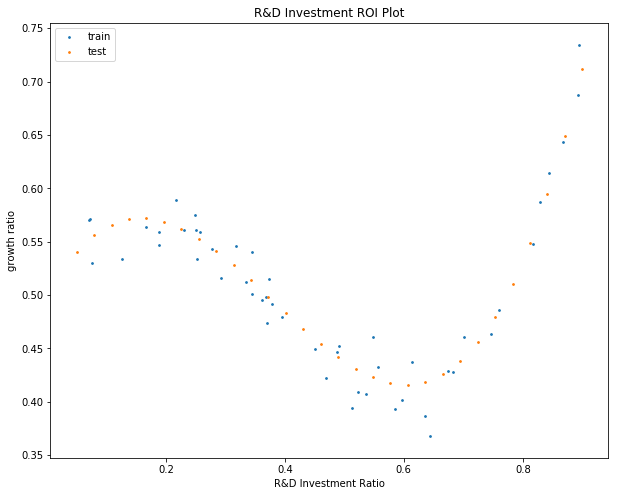

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths, s=3, label='train')
plt.scatter(test_invests, test_growths, s=3, label='test')
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.legend()
plt.show()

## 문제 1. L2 Regularization의 lambda 값에 따른 변화

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||^2\\
$$

이 수식에서 $\lambda$의 변화에 따라 어떤 식으로 움직이는 지 비교해 주세요

$
\lambda \in \{0.00001,0.0001,0.001,0.01,0.1\}
$

#### 답안지 입력란
* 아래에 답을 서술하여 주세요
* 아래 그래프에서 FIX ME 부분에 수식을 추가해 주세요
* weight decay 값인 beta는 placeholder로 추가해 주세요

In [0]:
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    beta = tf.placeholder(tf.float32, shape=(),name='beta')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(100, activation=tf.nn.relu,
                               kernel_initializer=he_init, name="hidden_1")(X)
    hidden_2 = tf.layers.Dense(100, activation=tf.nn.relu, 
                               kernel_initializer=he_init, name='hidden_2')(hidden_1)
    y_pred = tf.layers.Dense(1,kernel_initializer=xavier_init,
                             name='output')(hidden_2)
    
    # 손실 함수
    weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in weights])
    
    mse = tf.reduce_mean((y-y_pred)**2)
    loss = mse + beta * l2_loss
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))

#### 정답 확인
* 아래를 실행시키면 각 weight decay 별 결과가 시각화됩니다.
* 아래와 같은 결과가 나오면 정답입니다. 

![Imgur](https://i.imgur.com/rx9gjAC.png)

weight_decay = 1e-05


100%|██████████| 28000/28000 [00:54<00:00, 509.70it/s]

1000
weight_decay = 0.0001



100%|██████████| 28000/28000 [00:56<00:00, 495.67it/s]

1000
weight_decay = 0.001



100%|██████████| 28000/28000 [00:55<00:00, 507.00it/s]

1000
weight_decay = 0.01



100%|██████████| 28000/28000 [00:51<00:00, 544.68it/s]

1000
weight_decay = 0.1



100%|██████████| 28000/28000 [00:51<00:00, 540.95it/s]


1000


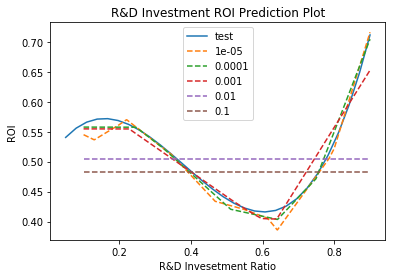

In [10]:
# 모델 학습시키기
with tf.Session(graph=graph) as sess:
    weight_decay_result = {}
    for weight_decay in [1e-5,1e-4,1e-3,1e-2,1e-1]:
        print("weight_decay = {}".format(weight_decay))
        sys.stdout.flush()
        # 가중치 초기화
        sess.run(tf.global_variables_initializer())

        for epoch in tqdm(range(28000)):
            sess.run(train_op,feed_dict={X:train_invests,
                                         y:train_growths,
                                         beta:weight_decay})

        # 0부터 1까지 순서대로 1000개를 출력
        test_xs = np.linspace(0.1,0.9,1000)
        test_xs = test_xs.reshape(-1,1)
        pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
        # 결과 저장
        print(len(pred_ys))
        weight_decay_result[weight_decay] = pred_ys
        
        
# 결과 시각화하기
plt.plot(test_invests, test_growths,label='test')
for label, pred_ys in weight_decay_result.items():
    plt.plot(test_xs, pred_ys,'--',label=label)

plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()        

## 문제 2. L1 Regularization의 lambda 값에 따른 변화

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||\\
$$
이 수식에서 $\lambda$의 변화에 따라 어떤 식으로 움직이는 지 비교해 주세요

$
\lambda \in \{0.00001,0.0001,0.001,0.01,0.1\}
$

#### 답안지 입력란
* 아래에 답을 서술하여 주세요
* 아래 그래프에서 FIX ME 부분에 수식을 추가해 주세요
* beta는 placeholder로 추가해 주세요

In [0]:
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    beta = tf.placeholder(tf.float32, shape=(),name='beta')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(100, activation=tf.nn.relu,
                               kernel_initializer=he_init, name="hidden_1")(X)
    hidden_2 = tf.layers.Dense(100, activation=tf.nn.relu, 
                               kernel_initializer=he_init, name='hidden_2')(hidden_1)
    y_pred = tf.layers.Dense(1,kernel_initializer=xavier_init,
                             name='output')(hidden_2)
    
    # 손실 함수
    weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    l1_loss = tf.add_n([tf.reduce_sum(tf.abs(weight)) for weight in weights])
    
    mse = tf.losses.mean_squared_error(y, y_pred)
    loss = mse + beta * l1_loss
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))

#### 정답 확인
* 아래를 실행시키면 각 weight decay 별 결과가 시각화됩니다.
* 아래와 같은 결과가 나오면 정답입니다. 

![Imgur](https://i.imgur.com/5YjaSda.png)


lambda = 1e-05


100%|██████████| 28000/28000 [00:47<00:00, 585.17it/s]

lambda = 0.0001



100%|██████████| 28000/28000 [00:49<00:00, 560.73it/s]

lambda = 0.001



100%|██████████| 28000/28000 [00:48<00:00, 575.46it/s]

lambda = 0.01



100%|██████████| 28000/28000 [00:51<00:00, 547.10it/s]

lambda = 0.1



100%|██████████| 28000/28000 [00:50<00:00, 550.27it/s]


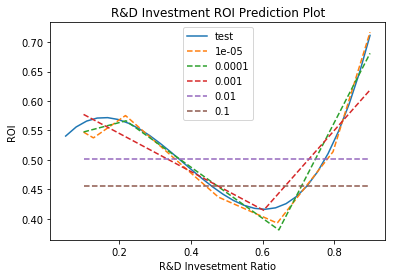

In [12]:
# 모델 학습시키기
with tf.Session(graph=graph) as sess:
    weight_decay_result = {}
    for weight_decay in [1e-5,1e-4,1e-3,1e-2,1e-1]:
        print("lambda = {}".format(weight_decay))
        sys.stdout.flush()
        # 가중치 초기화
        sess.run(tf.global_variables_initializer())

        for epoch in tqdm(range(28000)):
            sess.run(train_op,feed_dict={X:train_invests,
                                         y:train_growths,
                                         beta:weight_decay})

        # 0부터 1까지 순서대로 1000개를 출력
        test_xs = np.linspace(0.1,0.9,1000)
        test_xs = test_xs.reshape(-1,1)
        pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
        # 결과 저장
        weight_decay_result[weight_decay] = pred_ys
        
        
# 결과 시각화하기
plt.plot(test_invests, test_growths,label='test')
for label, pred_ys in weight_decay_result.items():
    plt.plot(test_xs,pred_ys,'--',label=label)

plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()        